In [1]:
import os
import sys
import pandas as pd
sys.path.append("../")
from dotenv import load_dotenv
from big_query import UniswapV3Data
load_dotenv()

True

In [2]:
univ3_data = UniswapV3Data(path='../data/', project_id=os.getenv("PROJECT_ID"), key_path=os.getenv("KEY_PATH"))
ETH_USDC_ADDRESS = "0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8"
swap_data = univ3_data.get_swap_data(address=ETH_USDC_ADDRESS, download_latest=False)
swap_data.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,sender,recipient,amount0,amount1,sqrtPriceX96,liquidity,tick
0,2021-05-05 01:56:23+00:00,12371376,0xce7c3c307d820785caa12938012372fc9366a614a6aa...,26,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xe592427a0aece92de3edee1f18e0157c05861564,0x5eefc9306f11a824762ccdaedac41049efc7fcc8,-329608,100000000000000,1377932816571815120446551350158799,4303369674465501,195285
1,2021-05-05 08:23:26+00:00,12373132,0x9a1c51b0bffbf840948f3b6e3f3e495ba1cd3fa64854...,192,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xe592427a0aece92de3edee1f18e0157c05861564,0xe592427a0aece92de3edee1f18e0157c05861564,-164694492,50000000000000000,1378850591292581266780357299649652,4303369674465501,195298
2,2021-05-05 09:50:51+00:00,12373520,0xc58715c62a5bf70a6ca09f0e51546d6cad76c8d4fff0...,8,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xe592427a0aece92de3edee1f18e0157c05861564,0xfb36693ac2dbe8dfc9f89dd0de6015c6ea66b0bf,-329169,100000000000000,1378852426842022799073024911548633,4303369674465501,195298
3,2021-05-05 11:59:57+00:00,12374077,0x288c21b8b4fbf449b1d086a06e43b124ac2bc088c3f5...,86,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xe592427a0aece92de3edee1f18e0157c05861564,0xfb36693ac2dbe8dfc9f89dd0de6015c6ea66b0bf,2,-329169,1378852426842016741051966412054516,4304946248093346,195298
4,2021-05-05 12:56:56+00:00,12374320,0x67502d8ba373287f6d301f6baa77c5a5f4c80d0753c3...,257,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xe592427a0aece92de3edee1f18e0157c05861564,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,1559137299,-467880854065813753,1370241555019945317645788135487819,4304946248093346,195173


In [3]:
# start_block, end_block = swap_data.block_number.iloc[0], swap_data.block_number.iloc[-1] 
# gas_price = univ3_data.get_gas_data(start_block, end_block)
# gas_price.head()

```Based on historic vol you can actually know what price what's the propability that our option expires ITM or OTM```

In [4]:
swap_data.block_timestamp =  pd.to_datetime(swap_data['block_timestamp'], origin='unix')
swap_data.set_index('block_timestamp', inplace=True)
# DATE_BEGIN                 = pd.to_datetime('2021-07-15 00:00PM',utc=True)
# DATE_END                   = pd.to_datetime('2021-08-15 00:00PM',utc=True)
# swap_data = swap_data[DATE_BEGIN:DATE_END]
DECIMALS_0 = 6
DECIMALS_1 = 18
swap_data['amount0']  = swap_data.amount0.astype('float')/(10**DECIMALS_0)
swap_data['amount1']  = swap_data.amount1.astype('float')/(10**DECIMALS_1)
swap_data['liquidity']  = swap_data.liquidity.astype('float')
swap_data['traded_in'] = swap_data.apply(lambda x: -x['amount0'] if (x['amount0'] < 0) else -x['amount1'],axis=1)
swap_data['traded_out'] = swap_data.apply(lambda x:  x['amount0'] if (x['amount0'] > 0) else  x['amount1'],axis=1)
swap_data['token_in']        = swap_data.apply(lambda x: 'token0' if (x['amount0'] < 0) else 'token1',axis=1)


price_data = pd.Series((1.0001**swap_data.tick.values)/10**(DECIMALS_1-DECIMALS_0),index=swap_data.index)

In [5]:
from rolling_strategy import RollingStrategy
import strategy_state 

Strategy = RollingStrategy(duration_param='14 day', percentage_param=0.3, buffer_param='7 day')
# Initial Position Details
INITIAL_TOKEN_0            = 100000
INITIAL_TOKEN_1            = INITIAL_TOKEN_0*price_data[0]
INITIAL_POSITION_VALUE     = 2*INITIAL_TOKEN_0
FEE_TIER                   = 0.003

output = strategy_state.simulate_strategy(price_data,swap_data,Strategy,INITIAL_TOKEN_0,INITIAL_TOKEN_1,fee_tier=FEE_TIER,decimals_0=DECIMALS_0,decimals_1=DECIMALS_1)

Initializing strategy...
Setting liquidity ranges: 7190931139908075
Setting liquidity ranges: 12793966573736272
Setting liquidity ranges: 8232711379539689
Setting liquidity ranges: 1909046133378255
Setting liquidity ranges: 2258672464834293
Setting liquidity ranges: 1186642299823554
Setting liquidity ranges: 2157370415159505
Setting liquidity ranges: 498833772511868
Setting liquidity ranges: 1010993496223160
Setting liquidity ranges: 475424794985975
Setting liquidity ranges: 586841121779888
Setting liquidity ranges: 27019481788863
Setting liquidity ranges: 535077997190748
Setting liquidity ranges: 25046982859550
Setting liquidity ranges: 455079552065280
Setting liquidity ranges: 29910285352460
Setting liquidity ranges: 457075246037429
Setting liquidity ranges: 32262234514579
Setting liquidity ranges: 435977340183402
Setting liquidity ranges: 52413567012322
Setting liquidity ranges: 118491625073043
Setting liquidity ranges: 23590917830264
Setting liquidity ranges: 107138080783055
Settin

In [6]:
sim_data = strategy_state.generate_simulation_series(output,Strategy)
strat_result = strategy_state.analyze_strategy(sim_data,INITIAL_POSITION_VALUE)

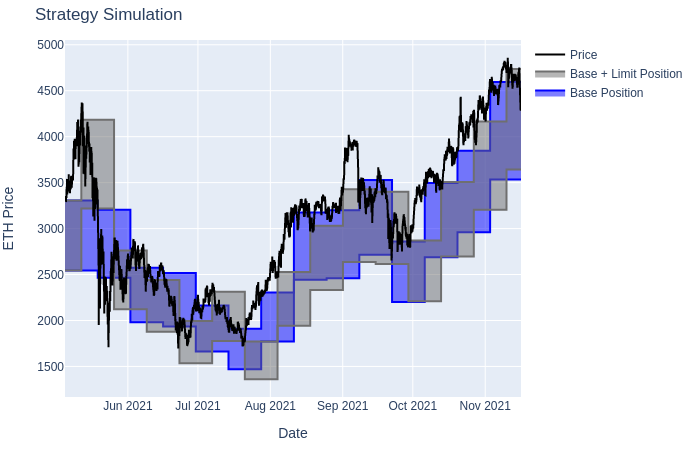

In [7]:
strategy_state.plot_strategy(sim_data,'ETH Price','#0000FF')

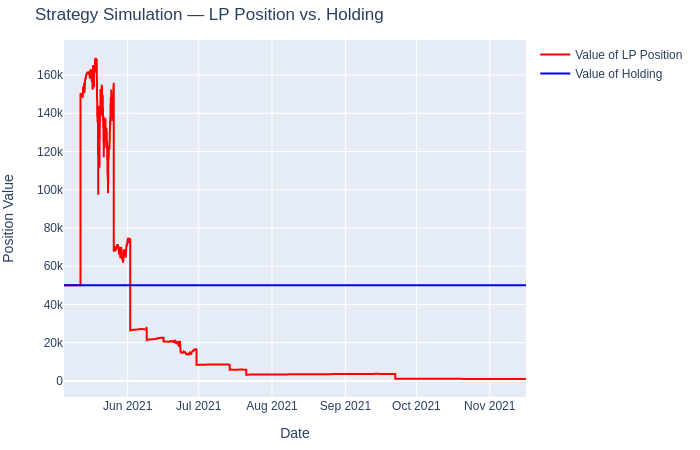

In [8]:
strategy_state.plot_position_value(sim_data)

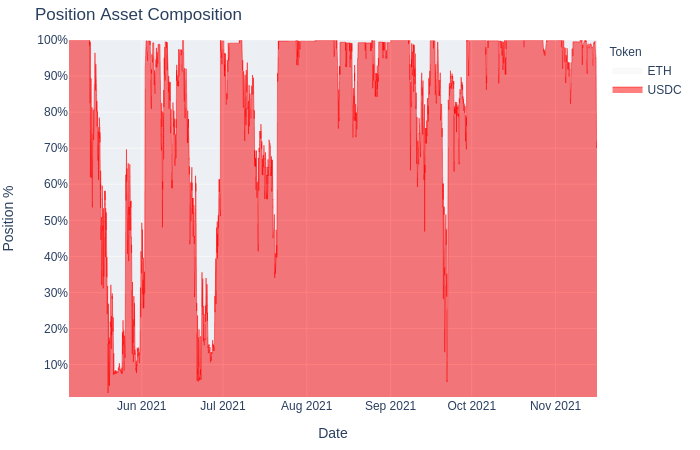

In [9]:
strategy_state.plot_asset_composition(sim_data, 'USDC', 'ETH')